In [1]:
# change the current dir so the sys know the .py modules
import os
os.chdir('/home/patrick/eye-tracking/python')

In [2]:
import ijson
import base64
import cv2
import random
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cnn_utils import *
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

## Get data from the DB

In [3]:
data = requests.get("https://gb.cs.unc.edu/json/drop",headers= { "Accept": "application/json" })

In [4]:
available_ids = []
for drop in data.json()['drops']:
    available_ids.append(drop['id'])
# available_ids

We need to exclude the bad IDs. Here we hardcode the bad IDs by using our [image filter website](http://patrickma.me/simple_filter/) 

In [5]:
bad_ids = [87,88,123,124,125,126,127,128,129,132,133,134,135,136,137,138,148,149,150,151,152,153,156,157,158,159,160,161,166,167,168,169,171,172,173,174,175,176,177,178,179,180,181,182,185,186,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,251,252,253,254,255,256,257,258,259,260,261,262,264,265,266,267,268,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,467,468,488,489,491,492,500,501,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551]

In [6]:
valid_ids = [x for x in available_ids if x not in bad_ids]

In [7]:
allData = []
for valid_id in valid_ids:
    data = requests.get('https://gb.cs.unc.edu/json/drop/'+str(valid_id))
    allData.append(data.json())

In [8]:
len(allData)

846

Save the valid data to a json file

In [9]:
import json
with open('../raw_data/dataset_062920.json', 'w', encoding='utf-8') as f:
    json.dump(allData, f, separators=(',', ':'))

In [10]:
df = create_dataframe('/../raw_data/dataset_062920.json')
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.49019607843137253, 0.4627450980392157, 0....","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.19607843137254902, 0.1568627450980392, 0....","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.2196078431372549, 0.19215686274509805, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.2196078431372549, 0.17647058823529413, 0....","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.5882352941176471, 0.5647058823529412, 0.6...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [11]:
x_train, x_validation, y_train, y_validation = create_train_validation(df)

In [12]:
# generate binary y labels
y_train_binary = create_binary_labels(y_train)
y_validation_binary = create_binary_labels(y_validation)

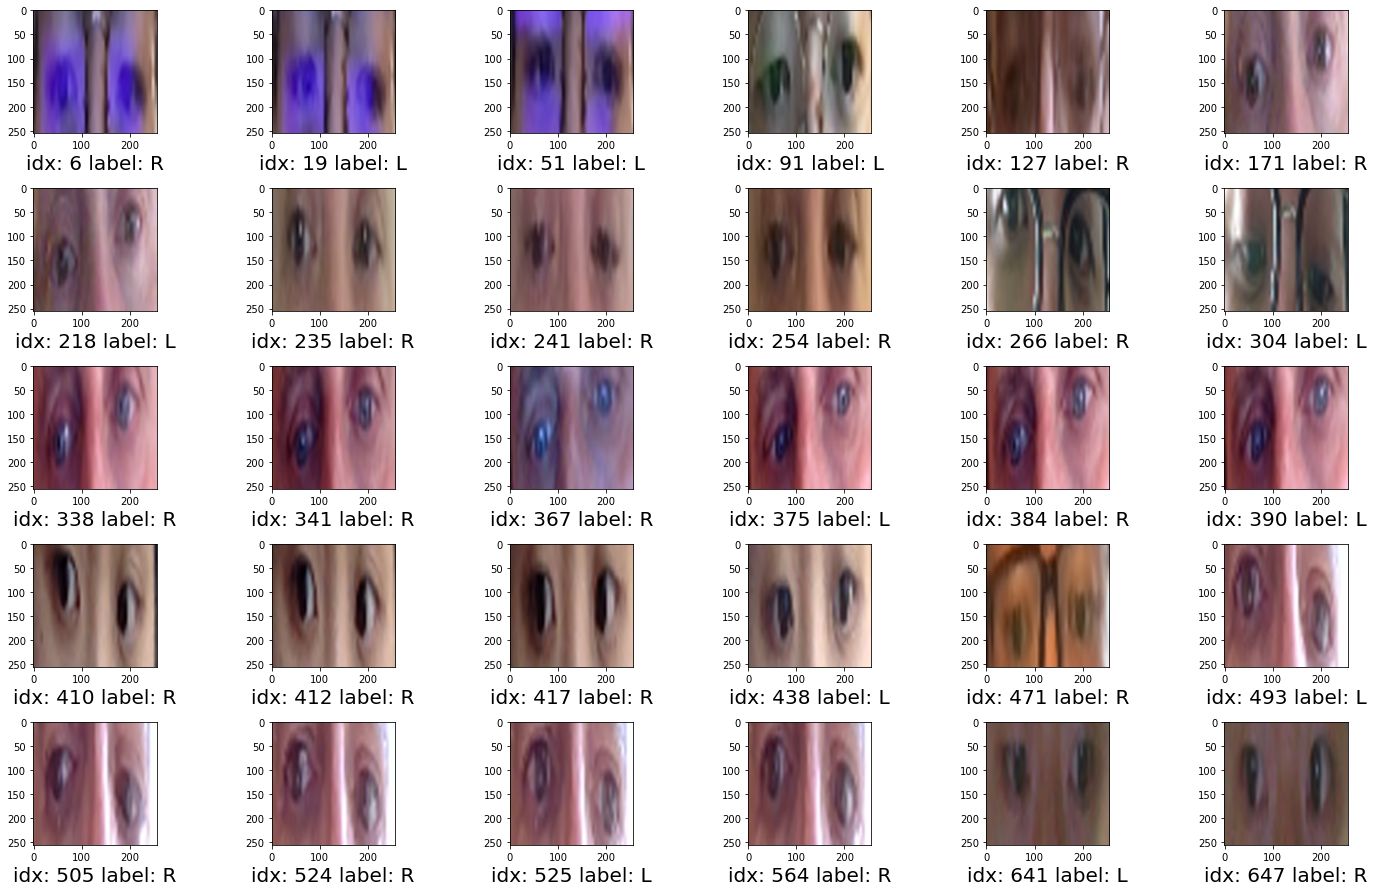

In [13]:
plot_eyeImages(x_train,y_train_binary)

## Simple CNN

In [14]:
IMG_WIDTH = x_train["eyeImage"].iloc[0].shape[1]
IMG_HEIGHT = x_train["eyeImage"].iloc[0].shape[0]

In [15]:
# def forward_propagation(eyeImage, leftEye, rightEye):
#     """
#     Implements the forward propagation for the model:
#     CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
#     Note that for simplicity and grading purposes, we'll hard-code some values
#     such as the stride and kernel (filter) sizes. 
#     Normally, functions should take these values as function parameters.
    
#     Arguments:

#     Returns:
#     Z3 -- the output of the last LINEAR unit
#     """
# #     eyeImage = tf.keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
# #     leftEye = tf.keras.layers.Input(shape=(12)) # requires the eye positions to be flattened to 1D
# #     rightEye = tf.keras.layers.Input(shape=(12))
#     conv = tf.keras.layers.Conv2D(filters=20, kernel_size=5, strides=1, activation='relu', kernel_initializer='VarianceScaling')(eyeImage)
#     maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(conv)
#     flat = tf.keras.layers.Flatten()(maxpool)
#     drop = tf.keras.layers.Dropout(rate=0.2)(flat)
#     concat = tf.keras.layers.concatenate([drop, leftEye, rightEye])
#     out = tf.keras.layers.Dense(units=2,activation="tanh",kernel_initializer='VarianceScaling')(concat)

#     simple_model = tf.keras.Model(inputs=[eyeImage, leftEye, rightEye], outputs=out, name="SimpleModel")
#     simple_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss = tf.keras.losses.MeanSquaredError())
    
#     return simple_model

### Compile the simple CNN

In [16]:
tf.convert_to_tensor(x_train["eyeImage"].iloc[0])

<tf.Tensor 'Const:0' shape=(256, 256, 3) dtype=float64>

In [17]:
# target = df.pop('y')

# dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))
data = {'X1':  [[1,2,3], [3,4,5]],
        'X2': [['a','b','c'],['c','d','e']]}
df = pd.DataFrame(data)
np.array(df)[1]

array([list([3, 4, 5]), list(['c', 'd', 'e'])], dtype=object)

In [18]:
def create_tf_data(X, Y):
    """
    take in the X and Y and transform each column into np array
    """
    
    eyeImage = np.stack(X['eyeImage'].to_numpy())
    leftEye = np.stack(X['leftEye'].to_numpy())
    rightEye = np.stack(X['rightEye'].to_numpy())
    y = np.stack(Y['y'].to_numpy())
    return eyeImage, leftEye, rightEye, y

In [19]:
eyeImage_train, leftEye_train, rightEye_train, binary_train = create_tf_data(x_train, y_train_binary)
eyeImage_test, leftEye_test, rightEye_test, binary_test = create_tf_data(x_validation, y_validation_binary)

In [20]:
# encode the y label to make it suitable for CNN
binary_encoder = LabelEncoder()
binary_encoder.fit(binary_train)
binary_train = binary_encoder.transform(binary_train)
binary_test = binary_encoder.transform(binary_test)

In [21]:
eyeImage = tf.keras.layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, 3))
leftEye = tf.keras.layers.Input(shape=(12)) # requires the eye positions to be flattened to 1D
rightEye = tf.keras.layers.Input(shape=(12))

conv = tf.keras.layers.Conv2D(filters=20, kernel_size=5, strides=1, activation='relu', kernel_initializer='VarianceScaling')(eyeImage)
maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(conv)
flat = tf.keras.layers.Flatten()(maxpool)
drop = tf.keras.layers.Dropout(rate=0.2)(flat)
concat = tf.keras.layers.concatenate([drop, leftEye, rightEye])
dense = tf.keras.layers.Dense(units=128,activation="relu",kernel_initializer='VarianceScaling')(concat)
out = tf.keras.layers.Dense(units=1,activation="sigmoid")(dense)
simple_model = tf.keras.Model(inputs=[eyeImage, leftEye, rightEye], outputs=out, name="SimpleModel")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
simple_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'],loss = tf.keras.losses.MeanSquaredError())

simple_model.summary()

Model: "SimpleModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 252, 252, 20) 1520        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 126, 126, 20) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 317520)       0           max_pooling2d[0][0]              
________________________________________________________________________________________

In [ ]:
simple_model.fit([eyeImage_train, leftEye_train, rightEye_train], binary_train, batch_size=64, epochs=100)

In [ ]:
test_loss, test_acc = simple_model.evaluate([eyeImage_test, leftEye_test, rightEye_test], binary_test)
print('Test accuracy:', test_acc)